# Your first deep neural network

# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Flatten, Dense, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.datasets import cifar10

# W&B integration for experiment tracking
import sys
sys.path.insert(0, '../..')
from utils.wandb_utils import init_wandb, get_metrics_logger
import wandb

2025-12-27 15:46:12.651300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


ModuleNotFoundError: No module named 'utils'

# data

In [ ]:
NUM_CLASSES = 10

In [ ]:
# Initialize W&B for experiment tracking
run = init_wandb(
    name="02_01_deep_neural_network",
    config={
        "model": "dense_network",
        "dataset": "cifar10",
        "num_classes": NUM_CLASSES,
        "hidden_layers": [200, 150],
        "learning_rate": 0.0005,
        "batch_size": 32,
        "epochs": 10,
        "optimizer": "adam",
    }
)

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [ ]:
x_train[54, 12, 13, 1] 

np.float32(0.36862746)

# architecture

In [ ]:
input_layer = Input((32,32,3))

x = Flatten()(input_layer)

x = Dense(200, activation = 'relu')(x)
x = Dense(150, activation = 'relu')(x)

output_layer = Dense(NUM_CLASSES, activation = 'softmax')(x)

model = Model(input_layer, output_layer)

I0000 00:00:1766777597.335377   24477 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       614,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,260 (2.47 MB)

 Trainable params: 646,260 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

# train

In [ ]:
opt = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.fit(x_train
          , y_train
          , batch_size=32
          , epochs=10
          , shuffle=True
          , validation_data=(x_test, y_test)  # Added for W&B metrics
          , callbacks=[get_metrics_logger()]  # W&B callback
          )

2025-12-26 19:33:21.587787: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.
2025-12-26 19:33:23.308360: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/10


2025-12-26 19:33:26.336996: I external/local_xla/xla/service/service.cc:163] XLA service 0x7411d00066b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-26 19:33:26.337162: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-12-26 19:33:26.492656: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-26 19:33:27.023907: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


  20/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.1531 - loss: 2.3636 

I0000 00:00:1766777609.402266   24668 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.3340 - loss: 1.8468
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4070 - loss: 1.6557
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4395 - loss: 1.5746
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4595 - loss: 1.5205
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.4724 - loss: 1.4804
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4831 - loss: 1.4514
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4915 - loss: 1.4237
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5012 - loss: 1.3998
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5078 - loss: 1.3787
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5174 - loss: 1.3573


# analysis

In [ ]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5017 - loss: 1.4106


[1.4106366634368896, 0.5016999840736389]

In [ ]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


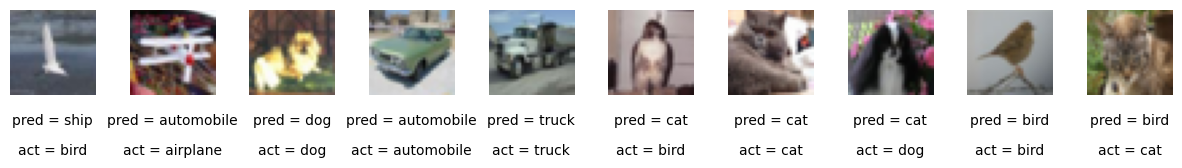

In [ ]:

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)


In [ ]:
# Finish W&B run
wandb.finish()